# Copyright

<PRE>
Copyright (c) 2024 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Convolutional Neural Network exercise

In this notebook, you will build a convolutional neural network, which offers superior results over the previous MLP solution. Additionally, you will perform a more detailed evaluation.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPool2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

2024-04-03 21:22:53.249509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [
                tf.config.LogicalDeviceConfiguration(memory_limit=8000)
            ],  # Set limit in MB
        )
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 2 Logical GPUs


2024-04-03 21:22:55.038495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 21:22:55.038680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 21:22:55.056366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# 1. Data
The dataset we will use is the well-known CIFAR10 (Canadian Institute For Advanced Research). Explore the details on the Keras website first: https://keras.io/api/datasets/cifar10/

There isn't much difference between the data preprocessing part and the one we did before. The only difference is that we don't have to reshape images into vectors, but we are working with a 4 dimensional data structure, where the dimensions are: batch, X, Y, and color channels.

In the event that anything is not clear regarding the data preparation part, please check the previous CIFAR10 notebook.

In [3]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [4]:
# it is in int8 format, the neural network requires float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [5]:
train_ratio = 0.8
train_length = X_train.shape[0]
train_split = int(train_ratio * train_length)
X_valid, Y_valid = X_train[train_split:], Y_train[train_split:]
X_train, Y_train = X_train[:train_split], Y_train[:train_split]

In [6]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

In [7]:
nb_classes = len(np.unique(Y_train))
Y_train = to_categorical(Y_train, nb_classes)
Y_valid = to_categorical(Y_valid, nb_classes)
Y_test = to_categorical(Y_test, nb_classes)

In [8]:
print(
    "Shapes of the training, validation and test input data:",
    X_train.shape,
    X_valid.shape,
    X_test.shape,
)
print(
    "Shapes of the training, validation and test output data:",
    Y_train.shape,
    Y_valid.shape,
    Y_test.shape,
)
print(
    "Mean values of the training, validation and test input data:",
    X_train.mean(),
    X_valid.mean(),
    X_test.mean(),
)
print(
    "Standard deviation of the training, validation and test input data:",
    X_train.std(),
    X_valid.std(),
    X_test.std(),
)

Shapes of the training, validation and test input data: (40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
Shapes of the training, validation and test output data: (40000, 10) (10000, 10) (10000, 10)
Mean values of the training, validation and test input data: 2.2788842e-09 0.0023437198 0.013331206
Standard deviation of the training, validation and test input data: 1.0000023 0.9965626 0.99783075


# 2. Exercise: training

Create and train a convolutional neural network with the following requirements:
* apply early stopping with patience=5 and monitor the validation accuracy, don't forget to load back the best weights after early stopping
* the number of trainable parameters is lower than 200.000
* the validation accuracy must be higher than 72%

Hints:
* you can always inspect the number of trainable parameters per layer with model.summary()
* usually the most trainable parameters are between the last convolutional layer and the next dense layer -- so you should have a reasonable output size at the last convolutional layer
* regularization helps (e.g. DropOut and/or BatchNormalization)
* use the right activation function at the output layer and the corresponding loss function
* for the chosen activation functions, please use the appropriate initialization method
* you can match the dimension of the last conv/pooling layer to the next dense layer with e.g. Flatten()
* ADAM optimizer is a reasonable choice
* don't forget to turn on GPU support in Colab, otherwise, it would be quite slow to train the networks



In [9]:
nb_classes = len(Y_train[0])

In [10]:
es = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)  # early stopping

In [11]:
# model definition
model = Sequential()
model.add(
    Conv2D(
        input_shape=[32, 32, 3],
        filters=40,
        kernel_size=7,
        strides=2,
        padding="same",
        activation="relu",
    )
)
model.add(BatchNormalization())
model.add(
    MaxPool2D(pool_size=2, strides=2, padding="same"),
)
model.add(Dropout(0.3))

model.add(
    Conv2D(
        filters=60,
        kernel_size=5,
        padding="same",
        activation="relu",
    )
)
model.add(BatchNormalization())
model.add(
    MaxPool2D(pool_size=2, strides=2, padding="same"),
)
model.add(Dropout(0.3))

model.add(
    Conv2D(
        filters=80,
        kernel_size=5,
        strides=2,
        padding="same",
        activation="relu",
    )
)
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu", kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(Dense(nb_classes, activation="softmax"))

# loss function and optimizer
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

2024-04-03 21:22:56.501830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 7.81GiB (8388608000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 40)        5920      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 40)       160       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 40)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 8, 40)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 60)          60060     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 60)         2

Please, check the number of trainable paramers:

In [13]:
print("#trainable parameters:", model.count_params())

#trainable parameters: 197510


In [14]:
# training
network_history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_valid, Y_valid),
    batch_size=32,
    epochs=1000,
    callbacks=[es],
)

Epoch 1/1000


2024-04-03 21:22:58.010548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-03 21:22:58.134673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-04-03 21:22:58.293125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-03 21:22:58.312734: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f168bbaa820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 21:22:58.312756: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-04-03 21:22:58.312759: I tensorflow/compiler/xla/service/service.cc:176]   St

1250/1250 [==============================] - 6s 3ms/step - loss: 1.5907 - accuracy: 0.4294 - val_loss: 1.2379 - val_accuracy: 0.5558
Epoch 2/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 1.2689 - accuracy: 0.5472 - val_loss: 1.1320 - val_accuracy: 0.6035
Epoch 3/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 1.1385 - accuracy: 0.5967 - val_loss: 1.0321 - val_accuracy: 0.6357
Epoch 4/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0584 - accuracy: 0.6288 - val_loss: 0.9193 - val_accuracy: 0.6761
Epoch 5/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0040 - accuracy: 0.6484 - val_loss: 0.8591 - val_accuracy: 0.7002
Epoch 6/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9516 - accuracy: 0.6641 - val_loss: 0.8686 - val_accuracy: 0.6983
Epoch 7/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9220 - accuracy: 0.6791 - val_loss: 0.8386 - val_accuracy

0.7702999711036682


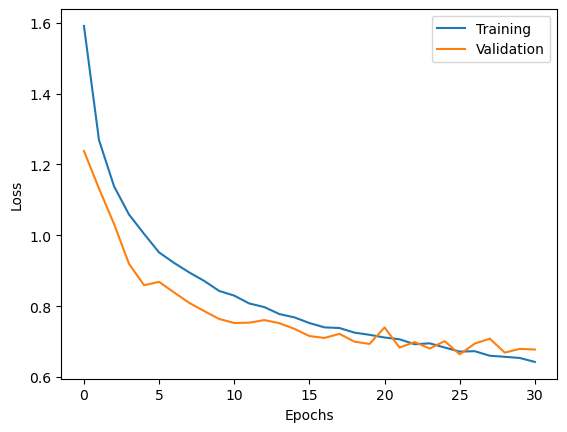

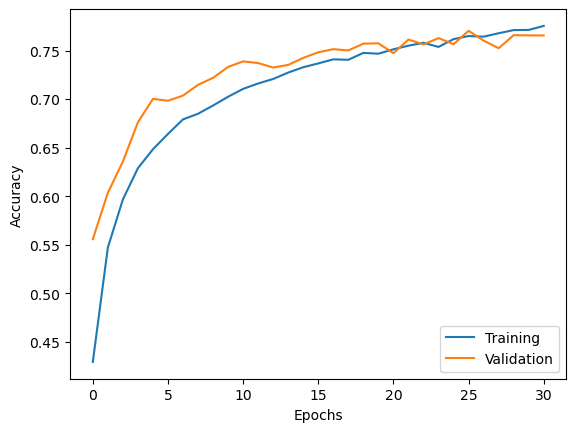

In [15]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(network_history.history["loss"])
    plt.plot(network_history.history["val_loss"])
    plt.legend(["Training", "Validation"])

    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(network_history.history["accuracy"])
    plt.plot(network_history.history["val_accuracy"])
    plt.legend(["Training", "Validation"], loc="lower right")
    plt.show()


print(max(network_history.history["val_accuracy"]))
plot_history(network_history)

# 3. Exercise: evaluation on test data
You will evaluate the classification of the test data using the common metrics and the confusion matrix in this section.


As a first stes, let's run the predictions and convert the predicted softmax outputs to dense labels. The one-hot encoded labels are also converted back to dense labels, as they are required for the evaluation functions.

In [16]:
probas = model.predict(X_test)
preds = np.argmax(probas, axis=1)
Y_test_dense = np.argmax(
    Y_test, axis=1
)  # get the original dense labels of the test data

313/313 [==============================] - 0s 957us/step


## 3.1. Exercise: Metrics
please review the common classification metrics (accuracy, precision, recall, F1) for the complete model (not per class).

Hints:
* use macro averaging
* you have to import the right functions from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)


In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [18]:
print("Accuracy:", accuracy_score(Y_test_dense, preds))
print("Precision:", precision_score(Y_test_dense, preds, average="macro"))
print("Recall:", recall_score(Y_test_dense, preds, average="macro"))
print("F1:", f1_score(Y_test_dense, preds, average="macro"))

Accuracy: 0.7659
Precision: 0.7633052233485955
Recall: 0.7659
F1: 0.7632403638756855



## 3.2. Exercise: Confusion matrix
Calculate the confusion matrix and display the results in a heatmap (with decimal values).

Hints:
* you have to do the imports this time too, e.g. from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and the [heatmap function](https://seaborn.pydata.org/generated/seaborn.heatmap.html) of [seaborn](https://seaborn.pydata.org/)
* for displaying the decimal values, you have to turn annot=True and define fmt='d' in the heatmap function of seaborn

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

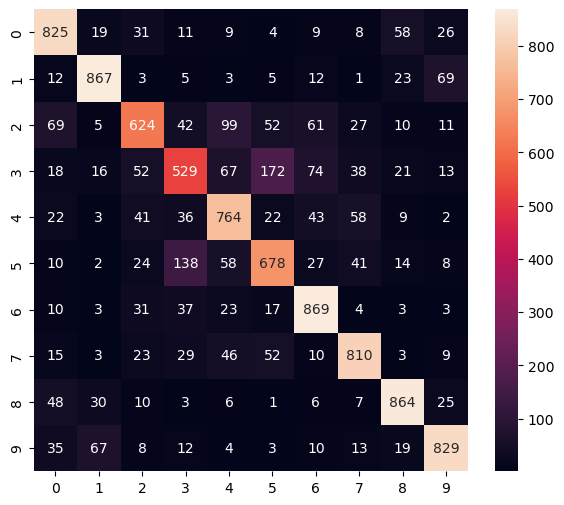

In [20]:
conf = confusion_matrix(Y_test_dense, preds)
plt.figure(figsize=(7, 6))

sns.heatmap(conf, annot=True, fmt="d")
plt.show()